# PA3 - Distributional Semantics Takes the SAT
    Eric Martin
    CS 542

## 1) Create distributional semantic word vectors


In [304]:
import numpy as np

# my other imports are in the notebook

In [305]:
# Assume this small dataset:

with open("./dist_sim_data.txt", "r") as f:
    dist_sim_data = f.readlines()
dist_sim_data = [x.strip() for x in dist_sim_data]  # remove the \n
dist_sim_data

['the men feed the dogs',
 'the women feed the dogs',
 'the women feed the men',
 'the men feed the men',
 'the dogs bite the men',
 'the dogs bite the women',
 'the dogs bite the dogs',
 'the dogs like the men',
 'the men like the women',
 'the women like the dogs',
 'the men like the dogs']

In [306]:
# count individual words

voc = list(set([item for sublist in [s.split() for s in dist_sim_data] for item in sublist]))
voc_dict = {voc[i]:i for i in range(len(voc))}
inv_voc_dict = {i:voc[i] for i in range(len(voc))}
voc_dict, inv_voc_dict

({'feed': 0, 'bite': 1, 'like': 2, 'dogs': 3, 'men': 4, 'women': 5, 'the': 6},
 {0: 'feed', 1: 'bite', 2: 'like', 3: 'dogs', 4: 'men', 5: 'women', 6: 'the'})

In [307]:
# compute cooccurrence matrix

cm = np.zeros((len(voc),len(voc)))
cm.shape

(7, 7)

In [308]:
for w in voc:
    for c in voc:
        if w != c:
            for sent in dist_sim_data:
                if w in sent.split() and c in sent.split()\
                    and abs(sent.split().index(w)-sent.split().index(c)) == 1:
                    cm[voc_dict[w],voc_dict[c]] += 1
cm

array([[0., 0., 0., 0., 2., 2., 0.],
       [0., 0., 0., 3., 0., 0., 0.],
       [0., 0., 0., 1., 2., 1., 0.],
       [0., 3., 1., 0., 0., 0., 4.],
       [2., 0., 2., 0., 0., 0., 4.],
       [2., 0., 1., 0., 0., 0., 3.],
       [0., 0., 0., 4., 4., 3., 0.]])

Each row is now a vector representing its coocurrence with other vocabulary items.

In [309]:
# inflate counts and smooth (you wouldn't need to inflate with appropriately-sized data)
cm *= 10  # inflate
cm += 1  # smooth
cm

array([[ 1.,  1.,  1.,  1., 21., 21.,  1.],
       [ 1.,  1.,  1., 31.,  1.,  1.,  1.],
       [ 1.,  1.,  1., 11., 21., 11.,  1.],
       [ 1., 31., 11.,  1.,  1.,  1., 41.],
       [21.,  1., 21.,  1.,  1.,  1., 41.],
       [21.,  1., 11.,  1.,  1.,  1., 31.],
       [ 1.,  1.,  1., 41., 41., 31.,  1.]])

In [310]:
# get a vector

cm[voc_dict["feed"]]

array([ 1.,  1.,  1.,  1., 21., 21.,  1.])

In [311]:
# normalize by the magnitude of the vectors
def cos_sim(a,b):
    return np.inner(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [312]:
cos_sim(cm[voc_dict["feed"]],cm[voc_dict["like"]])

0.8800686659691641

In [313]:
cos_sim(cm[voc_dict["feed"]],cm[voc_dict["men"]])

0.08416450561450177

In [314]:
cos_sim(cm[voc_dict["women"]],cm[voc_dict["men"]])

0.9834074604268053

The verbs and the nouns are more similar to each other than they are to the other class!

With a non-toy vocabulary it's a little more involved than *just* creating a cooccurrence matrix, but that's the first step.  One technique is to use positive pointwise mutual information (PPMI):

$$PPMI(w,c) = max\left(log\left(\frac{P(w,c)}{P(w)P(c)}\right),0\right)$$

Once weighted by PPMI, your word vectors can be decomposed using SVD, and be projected into lower dimensionalities in abstract semantic space.

So deep learning is not the only way to train word vectors, but is perhaps the most eye-catching!

    P(w) is the probability of a word, computed as the sum of its occurrences in the co-occurrence matrix divided by the total number of co-occurrences in the matrix.

    P(c) is similar, but for the context word.

    P(w,c) is the probability of their co-occurrence, computed as the frequency of the co-occurrence divided by the total number of co-occurrences.

In [315]:
# Calculate the total number of co-occurrences
total_cooccurrences = np.sum(cm)
total_cooccurrences

# Note this value is inflated

489.0

In [316]:
# Calculate probabilities P(w), P(c), and P(w, c)
P_w = np.sum(cm, axis=1) / total_cooccurrences
P_c = np.sum(cm, axis=0) / total_cooccurrences
P_wc = cm / total_cooccurrences

# Compute PPMI
# PPMI = np.maximum(np.log2(P_wc / (P_w[:, None] * P_c)), 0)  # p_w[:, None] is a trick to turn a 1D array into a 2D array
PPMI = np.maximum(np.log2(P_wc / (P_w * P_c)), 0)
# PPMI now contains the PPMI values for each word pair
PPMI

array([[0.        , 0.        , 0.        , 0.        , 0.44012109,
        1.1938297 , 0.        ],
       [0.        , 0.        , 0.        , 1.00199997, 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.44012109,
        0.26094389, 0.        ],
       [0.        , 3.46898023, 1.28394457, 0.        , 0.        ,
        0.        , 0.55051322],
       [2.21683037, 0.        , 2.21683037, 0.        , 0.        ,
        0.        , 0.55051322],
       [2.21683037, 0.        , 1.28394457, 0.        , 0.        ,
        0.        , 0.14715753],
       [0.        , 0.        , 0.        , 1.40535567, 1.40535567,
        1.75570858, 0.        ]])

## Visualize the actual words in the co-occurance matrix

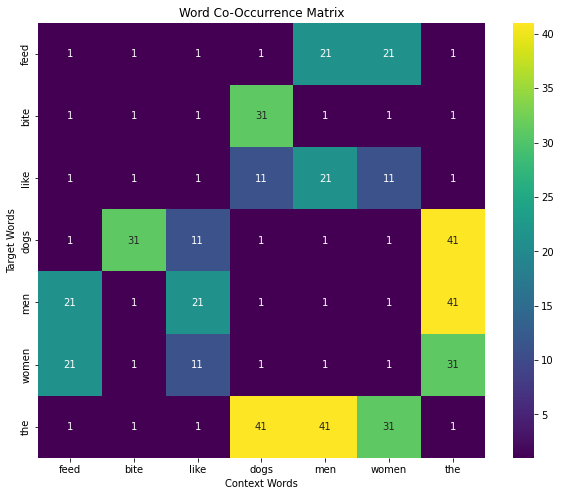

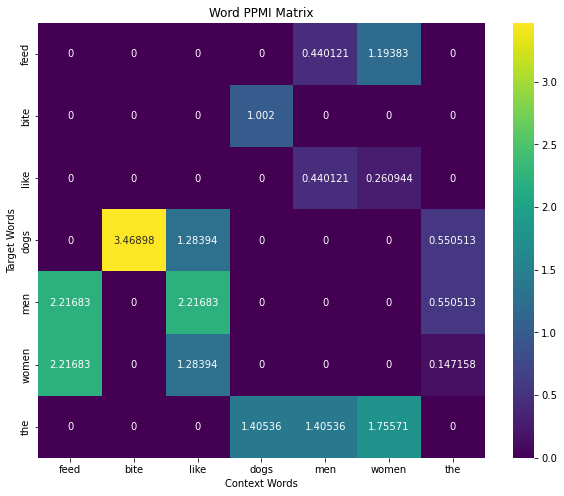

In [317]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'cm' is your co-occurrence matrix and 'voc' is your vocabulary list

# Convert the co-occurrence matrix to a DataFrame for better labeling in Seaborn
import pandas as pd
cm_df = pd.DataFrame(cm, index=voc, columns=voc)

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt="g", cmap="viridis")

plt.title("Word Co-Occurrence Matrix")
plt.xlabel("Context Words")
plt.ylabel("Target Words")
plt.show()


PPMI_df = pd.DataFrame(PPMI, index=voc, columns=voc)

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(PPMI_df, annot=True, fmt="g", cmap="viridis")

plt.title("Word PPMI Matrix")
plt.xlabel("Context Words")
plt.ylabel("Target Words")
plt.show()

## Comparing "dogs " before and after PPMI reweighting

What happened to the elements of this vector that had a smoothed count of 1 in the smoothed count matrix? What happened to the elements of this vector that had the same value (not 1) in the smoothed count matrix? You can look at the indices of these numbers in the word vector and determine what context word c they correspond to.


Does it seem like PPMI reweighting did the right thing with regard to the representation of each context word c in the word vector for “dogs”? Why? Explain in a few sentences how PPMI helps (short prose will do here; no need to show any math,rather just an intuitive understanding).


In [318]:
# Original co-occurrence matrix vector
cm[voc_dict["dogs"]]

array([ 1., 31., 11.,  1.,  1.,  1., 41.])

In [319]:
# Original co-occurrence matrix vector
PPMI[voc_dict["dogs"]]

array([0.        , 3.46898023, 1.28394457, 0.        , 0.        ,
       0.        , 0.55051322])

Questions:

**What happened to the elements of this vector that had a smoothed count of 1 in the smoothed count matrix? What happened to the elements of this vector that had the same value (not 1) in the smoothed count matrix?**

**Does it seem like PPMI reweighting did the right thing with regard to the representation of each context word c in the word vector for “dogs”? Why?**


These have been transformed to 0. The PPMI calculation seems to consider these co-occurrences as non-statistically significant about the relationship between "dogs" and these particular context words. If we look at these words we see they are 'dogs', 'men', and 'women'. We can see that these words don't co-occur with 'dogs' in our dataset.


For the co-occuring words with larger values, it seems the PPMI transformation has down-weighted these values but kept them positive based on how informative the pairs are. So while these words do co-occur with "dogs", their co-occurrence is not as uniquely informative as it might be for rarer word pairs so the word 'bite' we see shows the most information and then 'like' and then 'feed'.

The PPMI transformation of the word vector for "dogs" seems to have highlighted more meaningful and significant relationships while filtering out less informative ones. This makes the vectors more useful for tasks like semantic analysi since they better represent the word associations rather than just raw co-occurrence counts.

## Now that we have the semantic model, let's use it to do some semantic analysis

Compute the Euclidean (not cosine
as was done in Lecture 22) distance between the following pairs (you
can use the command scipy.linalg.norm to compute the length-
/norm of a vector):

    – “women” and “men” (human noun vs. human noun)
    – “women” and “dogs” (human noun vs. animal noun)
    – “men” and “dogs” (human noun vs. animal noun)
    – “feed” and “like” (human verb vs. human verb)
    – “feed” and “bite” (human verb vs. animal verb)
    – “like” and “bite” (human verb vs. animal verb)

Do the distances you compute above confirm our intuition from distributional semantics (i.e., similar words appear in similar contexts)?

In [320]:
def euclidean_dist(x,y):
    return np.sqrt(np.sum((x-y)**2))

# or 

from scipy.linalg import norm

def euclidean_dist_using_norm(x, y):
    return norm(x - y)


## Trying the distances with the original co-occurrence matrix

In [321]:
print('cm: "women" and "men" = ', euclidean_dist_using_norm(cm[voc_dict["women"]],cm[voc_dict["men"]]))
print('cm: "women" and "dogs" = ', euclidean_dist_using_norm(cm[voc_dict["women"]],cm[voc_dict["dogs"]]))
print('cm: "men" and "dogs" = ', euclidean_dist_using_norm(cm[voc_dict["men"]],cm[voc_dict["dogs"]]))
print('cm: "feed" and "like" = ', euclidean_dist_using_norm(cm[voc_dict["feed"]],cm[voc_dict["like"]]))
print('cm: "feed" and "bite" = ', euclidean_dist_using_norm(cm[voc_dict["feed"]],cm[voc_dict["bite"]]))
print('cm: "like" and "bite" = ', euclidean_dist_using_norm(cm[voc_dict["like"]],cm[voc_dict["bite"]]))

cm: "women" and "men" =  14.142135623730951
cm: "women" and "dogs" =  37.41657386773941
cm: "men" and "dogs" =  37.41657386773941
cm: "feed" and "like" =  14.142135623730951
cm: "feed" and "bite" =  41.23105625617661
cm: "like" and "bite" =  30.0


# Distances with the PPMI matrix

In [322]:
print('PPMI: "women" and "men" = ', euclidean_dist_using_norm(PPMI[voc_dict["women"]],PPMI[voc_dict["men"]]))
print('PPMI: "women" and "dogs" = ', euclidean_dist_using_norm(PPMI[voc_dict["women"]],PPMI[voc_dict["dogs"]]))
print('PPMI: "men" and "dogs" = ', euclidean_dist_using_norm(PPMI[voc_dict["men"]],PPMI[voc_dict["dogs"]]))
print('PPMI: "feed" and "like" = ', euclidean_dist_using_norm(PPMI[voc_dict["feed"]],PPMI[voc_dict["like"]]))
print('PPMI: "feed" and "bite" = ', euclidean_dist_using_norm(PPMI[voc_dict["feed"]],PPMI[voc_dict["bite"]]))
print('PPMI: "like" and "bite" = ', euclidean_dist_using_norm(PPMI[voc_dict["like"]],PPMI[voc_dict["bite"]]))

PPMI: "women" and "men" =  1.0163521730371832
PPMI: "women" and "dogs" =  4.136527116950844
PPMI: "men" and "dogs" =  4.221189014575109
PPMI: "feed" and "like" =  0.9328858041414629
PPMI: "feed" and "bite" =  1.6195492775916638
PPMI: "like" and "bite" =  1.1250787673194556


**Do the distances you compute above confirm our intuition from distributional semantics (i.e., similar words appear in similar contexts)?**

Yes, the words that have a smaller euclidean distance seem to be similar in how they are used. So "women" and "men" are very similar in the vector space whereas "feed" and "bite" are quite far. If the corpus was much larger, we could expect this technique to help us understand how words in a language are used in context.

## Decompose the matrix using SVD 

 Decompose the matrix using singular-value decomposition (SVD) by using the command scipy.linalg.svd, using the commands given below. 

In [323]:
import scipy

U, E, Vt = scipy.linalg.svd(PPMI, full_matrices=False)
U = np.matrix(U) # compute U
# print('U:\n ', U)
E = np.matrix(np.diag(E)) # compute E
# print('E:\n ', E)
Vt = np.matrix(Vt) # compute Vt = conjugate transpose of V
# print('Vt:\n ', Vt)
V = Vt.T # compute V = conjugate transpose of Vt
# print('V:\n ', V)

Verify I can recover the original matrix by multiplying U, E, and Vt together.

In [324]:
reconstructed_PPMI = U @ E @ Vt
print(reconstructed_PPMI)
print(PPMI)

[[-1.86715738e-16  1.32281014e-16 -5.81541264e-16 -5.89805982e-16
   4.40121086e-01  1.19382970e+00 -1.95726656e-16]
 [-1.02606637e-16  1.16903428e-15 -4.27172636e-18  1.00199997e+00
  -3.88578059e-16 -5.13478149e-16 -1.18392674e-16]
 [ 3.93793843e-17 -1.63877166e-17 -1.93432866e-18  7.63278329e-17
   4.40121086e-01  2.60943893e-01 -2.63375163e-17]
 [ 2.77555756e-17  3.46898023e+00  1.28394457e+00  8.72956621e-17
  -6.92950522e-17 -1.86102190e-17  5.50513220e-01]
 [ 2.21683037e+00  6.93889390e-16  2.21683037e+00  1.46545105e-16
   2.91837681e-17 -1.36391036e-16  5.50513220e-01]
 [ 2.21683037e+00 -8.32667268e-17  1.28394457e+00  2.22611283e-17
  -4.80729162e-18 -8.77832259e-17  1.47157526e-01]
 [ 1.09392935e-19  1.62966363e-17  3.03673889e-17  1.40535567e+00
   1.40535567e+00  1.75570858e+00 -1.51792150e-16]]
[[0.         0.         0.         0.         0.44012109 1.1938297
  0.        ]
 [0.         0.         0.         1.00199997 0.         0.
  0.        ]
 [0.         0.         0

### Are these values close enough to the original matrix?

Yes. Using the allclose method which I found, we can see that the values are close enough to the original matrix.

In [325]:
# Check if the reconstructed matrix is close to the original
np.allclose(PPMI, reconstructed_PPMI)

True

## Reduce dimensions to 3 to get word vectors

This way our word vectors will be in the abstract semantic space.

In [326]:
reduced_PPMI = PPMI @ Vt.T[:, 0:3]
reduced_PPMI

matrix([[ 2.63793974e-17, -1.02637475e-16, -1.06587727e+00],
        [-2.25965074e-17, -1.07767958e-16, -4.93706024e-01],
        [ 9.36421911e-18, -3.60166678e-17, -4.08635515e-01],
        [-2.53688176e+00, -2.74754068e+00,  3.15697960e-16],
        [-2.81383477e+00,  1.44868864e+00, -1.66688944e-16],
        [-2.14124648e+00,  1.35146299e+00, -2.19180497e-16],
        [ 1.50337369e-17, -3.32033343e-16, -2.64718100e+00]])

### Visualize the word vectors now that they are in 3D space

Out of curiosity I wanted to see what this reduced dimensionality matrix space looks like.

This is awesome because it shows the words that live in simiilar vector spaces like 'man' and 'woman' live near each other, whereas 'dog' and 'the' are off on their own and the verbs are in their own little space. 

This is a great way to visualize the semantic space of the words in our teeny tiny corpus!

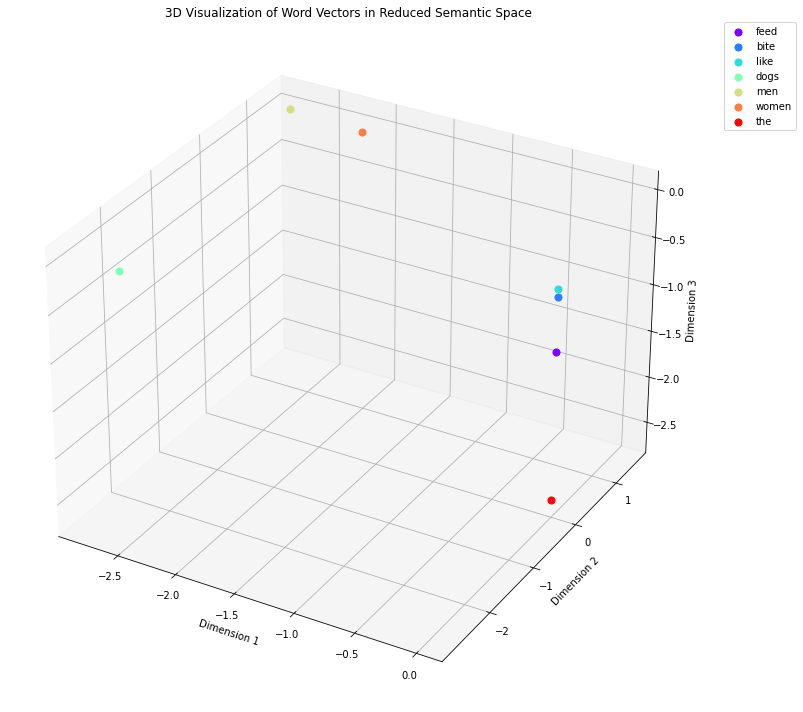

In [327]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Extract the coords of each word vector
x_coords = reduced_PPMI[:, 0].flat  # we use .flat to get a 1D iterator instead of a 2D array
y_coords = reduced_PPMI[:, 1].flat
z_coords = reduced_PPMI[:, 2].flat

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Make it pretty
colors = plt.cm.rainbow(np.linspace(0, 1, len(voc)))

# Make it legible
point_size = 50  # You can adjust this value as needed

# Scatter plot
for word, x, y, z, color in zip(voc, x_coords, y_coords, z_coords, colors):
    ax.scatter(x, y, z, color=color, label=word, s=point_size)

# Set labels
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')

# Title
ax.set_title('3D Visualization of Word Vectors in Reduced Semantic Space')

# legend
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

# Make it prettieer
plt.tight_layout()

plt.show()


### Compute the Euclidean distances of the human/animal nouns/verbs again but on the reduced PPMI-weighted count matrix. 

**Does the compact/reduced matrix still keep the information we need for each word vector?**


In [328]:
print('reduced_PPMI: "women" and "men" = ', euclidean_dist_using_norm(reduced_PPMI[voc_dict["women"]],reduced_PPMI[voc_dict["men"]]))
print('reduced_PPMI: "women" and "dogs" = ', euclidean_dist_using_norm(reduced_PPMI[voc_dict["women"]],reduced_PPMI[voc_dict["dogs"]]))
print('reduced_PPMI: "men" and "dogs" = ', euclidean_dist_using_norm(reduced_PPMI[voc_dict["men"]],reduced_PPMI[voc_dict["dogs"]]))
print('reduced_PPMI: "feed" and "like" = ', euclidean_dist_using_norm(reduced_PPMI[voc_dict["feed"]],reduced_PPMI[voc_dict["like"]]))
print('reduced_PPMI: "feed" and "bite" = ', euclidean_dist_using_norm(reduced_PPMI[voc_dict["feed"]],reduced_PPMI[voc_dict["bite"]]))
print('reduced_PPMI: "like" and "bite" = ', euclidean_dist_using_norm(reduced_PPMI[voc_dict["like"]],reduced_PPMI[voc_dict["bite"]]))

reduced_PPMI: "women" and "men" =  0.6795791580454789
reduced_PPMI: "women" and "dogs" =  4.118052733886603
reduced_PPMI: "men" and "dogs" =  4.2053588998359785
reduced_PPMI: "feed" and "like" =  0.6572417541271415
reduced_PPMI: "feed" and "bite" =  0.5721712457392658
reduced_PPMI: "like" and "bite" =  0.08507050838787567


Based on the results and the visualization, it seems like the reduced matrix still keeps the information we need for each word vector. The distances between the words are still similar to the original matrix. The visualization also shows that the words are still clustered in a similar way to the original matrix.

## 2) Computing with distributional semantic word vectors

We are given two types of word vectors:

1) Classical distributional semantic matrix. The matrix is trained using a 2-word context window, PPMI weighting, and SVD reduction to 500 dimensions. The co-occurrence statistics are computed from the British National Corpus and the Web-As-Corpus. It is trained by the COMPOSES toolkit. You could in fact make your own using the pipeline from Section 1, but SVD takes hours in a realistic setting—cubic time (O(n^3)) in the number of dimensions.

2) Google’s 300-dimensional word vectors trained by deep learning. The version we provide is trained on the Google News corpus and taken from the word2vec toolkit. We will see how their word vectors fare against the more classical method.


### Read in the word vectors

In [329]:
def load_word_vectors(file_path):
    word_vectors = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            word_vectors[word] = vector
    return word_vectors

google_word_vectors = load_word_vectors('./GoogleNews-vectors-rcv_vocab.txt')
COMPOSE_vectors = load_word_vectors('./EN-wform.w.2.ppmi.svd.500.rcv_vocab.txt')


### Read and parse the SAT analogy questions

I included the PoS tags thinkinng I may use them for handling unknown tokens, but I didn't end up using them. I left them in the code in case I want to use them later.

In [330]:
def parse_sat_questions(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    questions = []
    i = 0
    while i < len(lines):
        line = lines[i].strip()

        # Skip blank lines and commented lines
        if not line or line.startswith("#"):
            i += 1
            continue

        # Skip the header line of each question block
        i += 1

        # Read the question line (second line of the block)
        prompt_line = lines[i].strip().split()
        prompt_pair = tuple(prompt_line[:2])
        prompt_pos = tuple(prompt_line[2:])
        i += 1

        # Read the choices (next 5 lines)
        choices = []
        pos_pairs = []
        for j in range(5):
            choice_line = lines[i].strip().split()
            choice_pair = tuple(choice_line[:2])
            pos_pair = tuple(choice_line[2:])
            choices.append(choice_pair)
            pos_pairs.append(pos_pair)
            i += 1

        # Read the correct answer (8th line of the block)
        answer = lines[i].strip().lower()
        answer_index = ord(answer) - ord('a')  # convert it to a num
        i += 1

        questions.append({
            'prompt': prompt_pair,
            'choices': choices,
            'answer': answer_index,
            'part_of_speech': (prompt_pos, pos_pairs)
        })

        # Skip the blank line after each block
        i += 1

    return questions


sat_questions = parse_sat_questions('SAT-package-V3.txt')



### Example output of a parsed SAT question

In [331]:
sat_questions[0]

# Ok, it looks good.

{'prompt': ('lull', 'trust'),
 'choices': [('balk', 'fortitude'),
  ('betray', 'loyalty'),
  ('cajole', 'compliance'),
  ('hinder', 'destination'),
  ('soothe', 'passion')],
 'answer': 2,
 'part_of_speech': (('v:n',),
  [('v:n',), ('v:n',), ('v:n',), ('v:n',), ('v:n',)])}

## Handling unknown words using SAT question average vectors

If we encounter an unknown word, add all the vectors in the SAT question in the corresponding position (ie. if an unknown word is the left of the two choices, as in 'lull' in (('lull', 'trust')) take all the left words) that are known, and then divide by the total to get an average vector. Then use that average vector for the <unk> word.

This approach hopefully ensures that for each SAT question, unknown word are handled by using the average vector of the known words in the same position (left or right) within that specific question. This method may help provide a contextually relevant way to handle unknown words, tailored to the semantic content of each individual SAT question. 

This is opposed to just taking the part of speech tag and using the global vector average for that specific PoS tag.

And I boy oh boy was this a pain to do due to the left and right words and all that.


In [332]:
def calculate_average_vectors_for_each_question(sat_questions, word_vectors):
    question_averages = []
    total_unknown_words = 0  # Initialize a counter for unknown words

    for question in sat_questions:
        # shape of first vector in the dictionary
        vector_shape = next(iter(word_vectors.values()))

        # set sum_left and sum_right as zero vectors of the same shape as the word vectors
        sum_left = np.zeros_like(vector_shape)
        sum_right = np.zeros_like(vector_shape)

        count_left, count_right = 0, 0
        unknown_words = 0  # Counter for unknown words in the current question

        # here we iterate over the prompt and the choices and calculate the sum of the vectors
        for pair in [question['prompt']] + question['choices']:
            left_word, right_word = pair

            if left_word in word_vectors:
                sum_left += word_vectors[left_word]
                count_left += 1
            else:
                unknown_words += 1

            if right_word in word_vectors:
                sum_right += word_vectors[right_word]
                count_right += 1
            else:
                unknown_words += 1

        # Calculate the average vector for the left and right words in the question
        # If there are known left position words (count_left > 0), use average vector
        # else use a zero vector 
        avg_left = sum_left / count_left if count_left > 0 else np.zeros_like(sum_left)
        avg_right = sum_right / count_right if count_right > 0 else np.zeros_like(sum_right)
        question_averages.append((avg_left, avg_right))

        total_unknown_words += unknown_words

    print(f"Total number of unknown words encountered: {total_unknown_words}")
    return question_averages


# handles unknowns with my methodology
def get_vector(word_vectors, word, position, question_average_vectors):
    if word in word_vectors:
        return word_vectors[word]
    else:
        if position == 'left':
            return question_average_vectors[0]
        else:
            return question_average_vectors[1]



## Let's try using cosine similarity to find the most similar word to the analogy

I used this in a Spotify recommendation project so I want to give it a shot here.

I tried just using cosine similarity and it was not achieving the results I was hoping for. I was obtaining the following accuracies:

    Accuracy of Google vector set: 0.22192513368983957
    Accuracy of COMPOSE vector set: 0.24866310160427807

So I needed to implement something else to help improve the accuracy. I attempted normalizing the data but that had no effect. 

Cosine similarity will help identify if the word vectors are similar to each other. If the vectors are similar, then the words are similar (or at least used in similar contexts). The issue with this could be that antonyms may be very similar in the vector space. So we may need to use an additional methods to help better handle this situation.


In [333]:
import numpy as np
from scipy.spatial.distance import cosine

# handles the unknowns with my methodology
def cosine_similarity_between_words(word_vectors, word1, word2, position1, position2, average_vectors):
    vector1 = get_vector(word_vectors, word1, position1, average_vectors)
    vector2 = get_vector(word_vectors, word2, position2, average_vectors)
    
    similarity = 1 - cosine(vector1, vector2)
    
    return similarity


## Try implementing the vector difference to improve accuracy

In order to improve upon the cosine similarity, I implemented the vector difference method. 

Word vector spaces can have consistent patterns for similar word relationships. So taking the vector difference can reveal some relationships that are not identified from cosine similarity alone.

Example: Countries and thier languages (like "French" to "France", "ITalian" to "Italy") will have differences that reflect a language-to-country relationship. These differences are often similar across different language-country pairs, indicating a consistent semantic shift in the vector space.

Sooo, with the analogy problem we can hope that "A is to B as C is to D" implies a shift from A to B is semantically similar to the shift from C to D.

Annnnd, after implementing this addition, the accuracy improved by a ton! It practically doubled!

    Accuracy of Google vector set: 0.42780748663101603
    Accuracy of COMPOSE vector set: 0.41711229946524064


In [334]:

def vector_difference(word_vectors, word1, word2, position1, position2, average_vectors):

    vector1 = get_vector(word_vectors, word1, position1, average_vectors)
    vector2 = get_vector(word_vectors, word2, position2, average_vectors)
    return vector2 - vector1

## Prediction time

Here I attempt to predict the correct answers to the SAT questions using the Google and COMPOSE vector sets.

Using the cosine similarity with the average value unknown word handling provided lack-luster results, seen below:

    Accuracy of Google vector set: 0.22192513368983957
    Accuracy of COMPOSE vector set: 0.24866310160427807

When I handled the unknown words by just using a zero vector the accuracy was even lower at around 0.20 and 0.21

After I implemented the vector difference method, the accuracy significantly improved:

    Accuracy of Google vector set: 0.42780748663101603
    Accuracy of COMPOSE vector set: 0.41711229946524064

The google word vector set outperformed the Compose word vector set by about 1.0% in accuracy. This is not a huge difference but it is impressive since not only did it have a smaller dimensionality (300 vs 500) but it was also trained on a smaller corpus (Google News vs British National Corpus and Web-As-Corpus). It also had more unknown words to handle since it was trained on a smaller corpus but still outperformed the Compose corpus.

It shows that deep learning shows promise to create smaller and more efficient word vector sets that can be used for semantic analysis as opposed to the more traditional SVD method.

In [335]:

def predict_answer(question, word_vectors, question_average_vectors):
    question_vector = vector_difference(
        word_vectors, question['prompt'][0], question['prompt'][1], 
        'left', 'right', question_average_vectors)

    best_choice = None
    best_similarity = -1

    for i, choice in enumerate(question['choices']):
        choice_vector = vector_difference(
            word_vectors, choice[0], choice[1], 
            'left', 'right', question_average_vectors)

        # Cosine similarity between stem_vector and choice_vector
        similarity = 1 - cosine(question_vector, choice_vector)

        if similarity > best_similarity:
            best_similarity = similarity
            best_choice = i

    return best_choice

In [336]:
def evaluate_accuracy(sat_questions, word_vectors):
    correct_answers = 0
    question_averages = calculate_average_vectors_for_each_question(sat_questions, word_vectors)

    for question, averages in zip(sat_questions, question_averages):
        predicted = predict_answer(question, word_vectors, averages)
        if predicted == question['answer']:
            correct_answers += 1

    return correct_answers / len(sat_questions)

In [337]:
# Calculate accuracy
accuracy_google = evaluate_accuracy(sat_questions, google_word_vectors)
accuracy_compose = evaluate_accuracy(sat_questions, COMPOSE_vectors)
print(f"Accuracy of Google vector set: {accuracy_google}")
print(f"Accuracy of COMPOSE vector set: {accuracy_compose}")

Total number of unknown words encountered: 174
Total number of unknown words encountered: 172
Accuracy of Google vector set: 0.42780748663101603
Accuracy of COMPOSE vector set: 0.41711229946524064
